# Multivariate Generalized Gaussian Spatial Model

## Generative Model with Stochastic representation: $\mathbf{x} = \tau \Sigma^{1/2} \mathbf{u}$
1. $\mathbf{u} \in \mathbb{R}^2$ is a random vector sampled from a unit circle
2. Scatter matrix $\Sigma = m \mathbf{M}$
3. Shape parameter $\beta$
4. $\tau^{2 \beta} \sim \Gamma(\frac{p}{2 \beta}, 2)$

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.stats import special_ortho_group


def random_scatter(m=1, p=2):
    M = np.random.rand(p, p)
    M = 0.5 * (M + M.T)
    return m * M / M.trace()


class MultiVarGenGaussian:
    def __init__(self, mu, Sigma, beta, p=2):
        self._p = p
        self._mu = mu
        self._beta = beta
        self.Sigma = Sigma

    @property
    def dim(self):
        return self._p

    @dim.setter
    def dim(self, val):
        self._p = val

    @property
    def mu(self):
        return self._mu

    @mu.setter
    def mu(self, val):
        self._mu = val

    @property
    def Sigma(self):
        return self._Sigma

    @Sigma.setter
    def Sigma(self, val):
        if val:
            self._Sigma = val
        else:
            self._Sigma = random_scatter(1, self._p)

    @property
    def beta(self):
        return self._beta

    @beta.setter
    def beta(self, val):
        self._beta = val

    def sample(self, n_samples=1000, noise_level=0):
        phi = 2 * np.pi * np.random.random(n_samples)
        u = np.array([np.cos(phi), np.sin(phi)]) + self._mu[:, np.newaxis]
        tau = np.power(
            np.random.gamma(0.5 * self._p / self._beta, 2, n_samples), 0.5 / self._beta
        )
        x = tau * np.matmul(np.sqrt(self._Sigma), u)
        R = special_ortho_group.rvs(self._p)
        x = np.matmul(R, x)
        if noise_level > 0:
            mu = self._mu[:, np.newaxis]
            sigma = np.std(x, axis=1)[:, np.newaxis]
            x += sigma * np.random.randn(self._p, x.shape[1]) + mu

        return x

    def pdf(self, X):
        d = X.shape[1]
        diff = X - self._mu
        exponent = -0.5 * np.sum(
            np.power(np.dot(diff, np.linalg.inv(self._Sigma)), 2), axis=1
        )
        exponent = np.power(1 + exponent / self._beta, -(self._beta + d) / 2)
        return np.prod(exponent)

    def log_likelihood(self, X):
        return np.sum(np.log(self.pdf(X)))


def estimate_params(X):
    n, d = X.shape
    mu0 = np.mean(X, axis=0)
    Sigma0 = np.cov(X.T)
    beta0 = 3.0
    model = MultiVarGenGaussian(mu0, Sigma0, beta0)
    res = minimize(lambda beta: -model.log_likelihood(X), beta0, method="BFGS")
    beta_hat = res.x[0]
    model.beta = beta_hat
    return model

### Animate Sampling Process

In [ ]:
mvgg = MultiVarGenGaussian(mu=np.random.rand(2) * 10 - 5, Sigma=None, beta=0.5, p=2)
x = mvgg.sample(2000, 0.25)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect(1)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
dots = ax.scatter(x[0, :], x[1, :])


def init():
    x = mvgg.sample(2000, 0.25)
    dots.set_offsets(x.T)
    return dots


def update(frame):
    x = mvgg.sample(2000, 0.25)
    dots.set_offsets(x.T)
    ax.set_xlim(x[0, :].min() - 1, x[0, :].max() + 1)
    ax.set_ylim(x[1, :].min() - 1, x[1, :].max() + 1)

    return dots


ani = FuncAnimation(
    fig, update, repeat=False, frames=10, interval=400, init_func=init, blit=True
)

plt.suptitle("MGGD Generative Model")
plt.show()

## Neuronal Multivariate Generalized Gaussian Process (NMGGP)

In [204]:
%matplotlib widget

import matplotlib.pyplot as plt
import nengo
import numpy as np
from matplotlib.animation import FuncAnimation
from TouchDataset import TouchDataset

# Prepare dataset
dataset = TouchDataset(filepath="../data/touch.pkl", noise_scale=0.2, scope=(-1.0, 1.0))
X_train, y_train, X_test, y_test = dataset.split_set(ratio=0.5)
height, width = X_train[0].shape
n_dims = height * width

# Simulation parameters
dt = 1e-3
duration = (len(X_train) - 1) * dt
frames = int(duration // dt)
max_rates = 200
n_steps = 200

ens_params = dict(radius=1, intercepts=nengo.dists.Gaussian(0, 0.1))

conn_config = dict(
    learning_rule_type=nengo.PES(learning_rate=1e-4),
    synapse=dt,
)


def input_func(t):
    index = int(t / dt) // n_steps
    sample = X_train[index].flatten()
    return sample


probes = dict()

# Create the Nengo model
with nengo.Network(label="NMGGP") as model:
    stim = nengo.Node(input_func)
    inp = nengo.Ensemble(
        n_neurons=stim.size_out,
        dimensions=1,
        radius=1,
        max_rates=np.ones(stim.size_out) * max_rates,
        intercepts=np.zeros(stim.size_out),
        neuron_type=nengo.PoissonSpiking(nengo.LIFRate()),
    )
    hidden = nengo.Ensemble(
        n_neurons=100, dimensions=1, radius=1, intercepts=np.zeros(100)
    )

    # Output layer
    sigma = nengo.Ensemble(n_neurons=10, dimensions=4, **ens_params)
    tau = nengo.Ensemble(n_neurons=10, dimensions=1, **ens_params)

    nengo.Connection(stim, inp.neurons, transform=1, synapse=None)
    conn_inp_hidden = nengo.Connection(
        inp.neurons,
        hidden.neurons,
        transform=np.random.normal(0, 0.5, size=(hidden.n_neurons, inp.n_neurons)),
        **conn_config
    )
    nengo.Connection(
        hidden.neurons,
        sigma,
        transform=np.random.normal(0, 0.5, size=(sigma.dimensions, hidden.n_neurons)),
        **conn_config
    )
    nengo.Connection(
        hidden.neurons,
        tau,
        transform=np.random.normal(0, 0.5, size=(tau.dimensions, hidden.n_neurons)),
        **conn_config
    )

    # Define probes
    inp_probe = nengo.Probe(inp, synapse=0.01)
    inp_spike = nengo.Probe(inp.neurons)
    hidden_probe = nengo.Probe(hidden, synapse=0.01)
    hidden_spike = nengo.Probe(hidden.neurons)
    tau_probes = nengo.Probe(sigma, synapse=0.01)
    tau_spikes = nengo.Probe(sigma.neurons, synapse=0.01)


# Simulate the network
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(duration)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

### Plot results

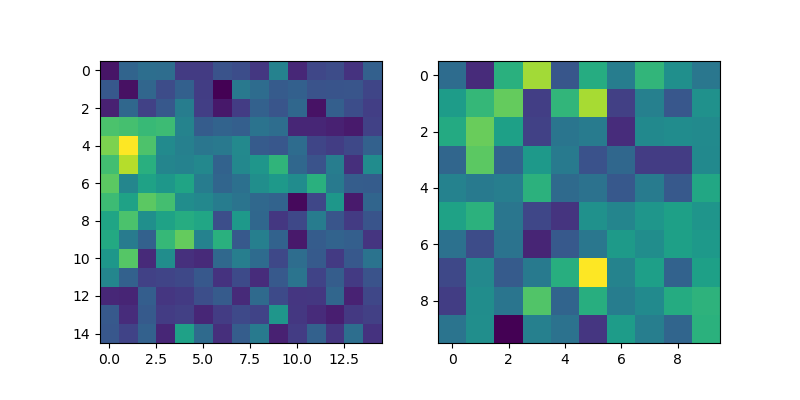

In [205]:
plt.close("all")
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

spikes = np.sum(sim.data[hidden_spike], axis=0).reshape((10, 10))
sample = input_func(t)
ax[0].imshow(sample.reshape((15, 15)))
ax[1].imshow(spikes)
plt.show()